In [1]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()  # current working directory

# Assume 'ml' folder is in the repo root, one level up from notebooks/
repo_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add repo root to Python path if not already there
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Introduction/Motivation
TODO: Write an introduction
- What problems does Linear regression solve?
- Real-world examples where it is used
- Why understanding it deeply is important

# Dataset Loading
I'm now going to load a dataset for practice.
I'll start with a synthetic dataset so I can control its properties:
- Number of samples
- Noise level
I'm going to keep the number of features at 1 so I can visualize the results easily.
This allow us to test how the algorithm behaves with different inputs and visualize the results in 2D.

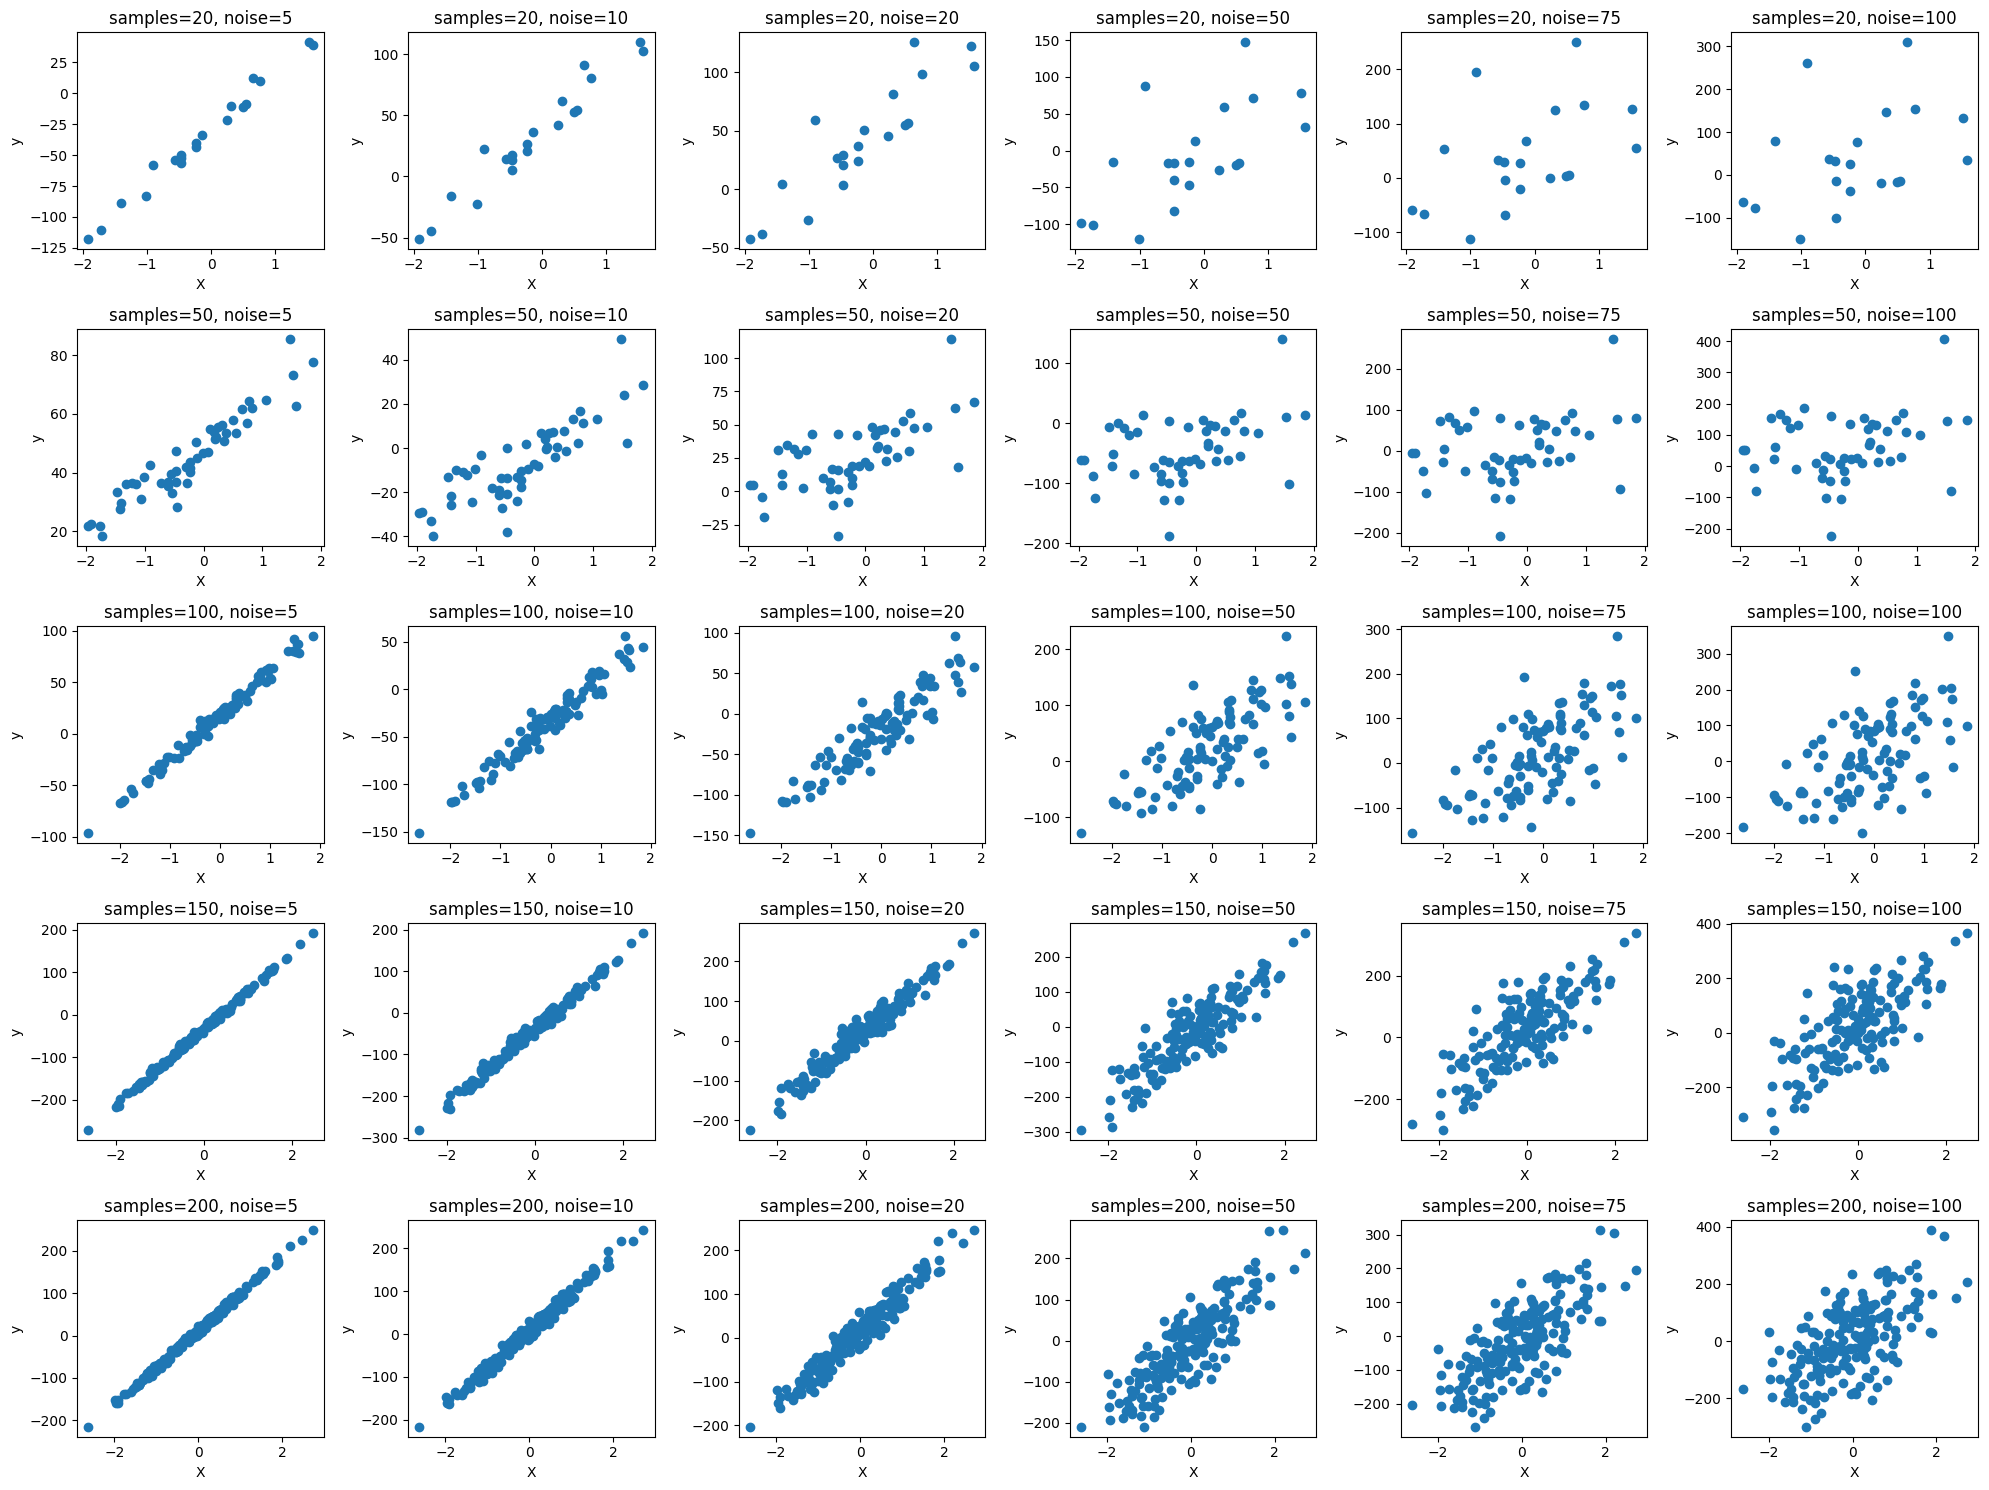

In [ ]:
from data.load_data import load_synthetic_regression
import matplotlib.pyplot as plt
import numpy as np

# Let's first define the parameter ranges
sample_sizes = [20, 50, 100, 150, 200]
noise_levels = [5, 10, 20, 50, 75, 100]


# Initialize a dictionary to hold datasets
datasets = {}

# Decide the figure layout
fig, axes = plt.subplots(len(sample_sizes), len(noise_levels), figsize=(20, 15))

# Loop through the grid
for i, sample in enumerate(sample_sizes):
    for j, noise in enumerate(noise_levels):
        bias_val = np.random.uniform(-50, 50)  # random bias in some range
        key = f"samples_{sample}_noise_{noise}_bias_{bias_val:.1f}"
        X, y, bias = load_synthetic_regression(n_samples=sample, n_features=1, noise=noise, random_state=42, bias=bias_val)
        datasets[key] = (X, y, bias_val)
        # Plot the points using scatter
        ax = axes[i, j]
        ax.scatter(X, y)
        ax.set_title(f"samples={sample}, noise={noise}")
        ax.set_xlabel("X")
        ax.set_ylabel("y")

plt.tight_layout()


# Data processing
Let's continue with preprocessing.
1. Feature scaling: not required for linear regression because the coefficients will adjust to the scale automatically. But it helps if we want gredient descent to converge faster. In this case we only have 1 feature, but it could be interesting with more features. ## TODO
2. Centering: centering features can improve numerical stability because all features are around the same origin. 
3. Adding an intercept: I'm not going to apply it yet. Let's see if the model is forced to go through the origin.

In [3]:
from sklearn.model_selection import train_test_split

datasets_splits = {}
for key, data in datasets.items():
    X, y, bias = data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    datasets_splits[key] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "bias": bias,
        "n_samples": sample,
        "noise": noise
    }


# Training the model

TODO: Fit the model
- Track loss per iteration
- Experiment: what happens if we increase/decrease lr or n_iters?

In [4]:
list(datasets_splits.keys())[15]

'samples_100_noise_50_bias_25.0'

In [5]:
import imageio
import numpy as np
from ml.models.linear_model import LinearRegression

key = list(datasets_splits.keys())[15]
data = datasets_splits[key]
X_train, y_train, X_test, y_test = data["X_train"], data["y_train"], data["X_test"], data["y_test"]

frames = []

model = LinearRegression(lr=0.1, n_iters=1000)
model.fit(X_train, y_train, X_test, y_test)

for i, (W, b) in enumerate(model.params_history):
    if i % 10 == 0:
        y_pred_train = X_train.dot(W) + b
        y_pred_test = X_test.dot(W) + b
        loss_train = model.loss_history[i]
        loss_test = model.test_loss_history[i]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Top: scatter + line
        ax1.scatter(X_train, y_train, color='blue', label='Train')
        ax1.scatter(X_test, y_test, color='orange', label='Test')
        x_line = np.linspace(X_train.min(), X_train.max(), 100)
        y_line = W * x_line + b
        ax1.plot(x_line, y_line, color='red', label='Model')
        ax1.legend()
        ax1.set_title(f"Iteration {i}")
        
        # Bottom: loss curves
        ax2.plot(range(i+1), model.loss_history[:i+1], color='blue', label='Train Loss')
        ax2.plot(range(i+1), model.test_loss_history[:i+1], color='orange', label='Test Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('MSE')
        ax2.legend()
        
        # Convert figure to image and append to frames
        fig.canvas.draw()  # Render the figure
        frame = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA
        frame = frame[:, :, :3] 
        frames.append(frame)
        plt.close(fig)  # close to save memory
    
imageio.mimsave('linear_regression_training_more_lr.gif', frames, duration=0.1)

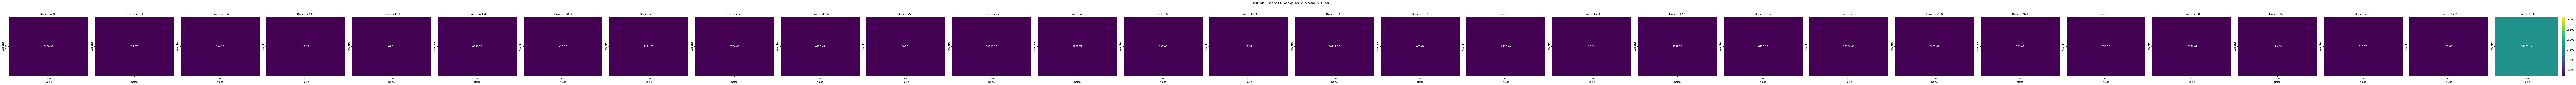

In [ ]:
import pandas as pd
import plotly.express as px

results = {}

for key, data in datasets_splits.items():
    X_train, y_train = data["X_train"], data["y_train"]
    X_test, y_test = data["X_test"], data["y_test"]

    model = LinearRegression(lr=0.01, n_iters=1000)
    model.fit(X_train, y_train, X_test, y_test)

    results[key] ={
        "dataset": key,
        "samples": data["n_samples"],
        "noise": data["noise"],
        "bias": data["bias"],
        "train_mse": model.loss_history[-1],
        "test_mse": model.test_loss_history[-1],
        "loss_curve_train": model.loss_history,   # full curve
        "loss_curve_test": model.test_loss_history  # full curve
    }

# Convertir resultados a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Aseguramos que sean numéricos
df_results["samples"] = df_results["samples"].astype(int)
df_results["noise"] = df_results["noise"].astype(int)
df_results["bias"] = df_results["bias"].astype(float)

# Valores únicos de bias
bias_values = sorted(df_results["bias"].unique())

# Crear grid de subplots (1 fila por bias)
fig, axes = plt.subplots(1, len(bias_values), figsize=(5 * len(bias_values), 5), sharey=True)

if len(bias_values) == 1:
    axes = [axes]  # asegurar que axes sea iterable

for ax, bias in zip(axes, bias_values):
    # Filtrar por bias
    df_bias = df_results[df_results["bias"] == bias]

    # Pivotear a formato de matriz (rows = samples, cols = noise)
    heatmap_data = df_bias.pivot_table(
        index="samples",
        columns="noise",
        values="test_mse"
    )

    # Dibujar heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        ax=ax,
        cbar=(ax == axes[-1])  # solo mostrar la barra de color en el último subplot
    )
    ax.set_title(f"Bias = {bias:.1f}")
    ax.set_xlabel("Noise")
    ax.set_ylabel("Samples")

plt.suptitle("Test MSE across Samples × Noise × Bias", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Insights
- How weights relate to the slope of the line
- How bias affects predictions
- How the learning rate influences convergence
- How noise affects prediction accuracy
- What would happen with multiple features?